In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [30]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [39]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [40]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [42]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # 每一个 neuron 的 firing rate 会 exactly 变成 unit gaussian on this mini-batch(这个例子中是 32 examples)
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())


      0/ 200000: 3.3231
  10000/ 200000: 2.2956
  20000/ 200000: 2.2664
  30000/ 200000: 2.0895
  40000/ 200000: 2.4135
  50000/ 200000: 2.0058
  60000/ 200000: 2.2593
  70000/ 200000: 2.0113
  80000/ 200000: 2.0227
  90000/ 200000: 1.9301
 100000/ 200000: 2.4192
 110000/ 200000: 1.9542
 120000/ 200000: 2.0902
 130000/ 200000: 2.4328
 140000/ 200000: 2.0951
 150000/ 200000: 2.2058
 160000/ 200000: 2.0108
 170000/ 200000: 2.0335
 180000/ 200000: 2.0490
 190000/ 200000: 2.0957


In [9]:
# Loss log

# original:
train 2.1210389137268066
val 2.1784117221832275

# fix softmax confidently wrong:
# 通过把 logits 控制在 close to 0; 即通过 W2*0.01 以及 b2*0
train 2.067570209503174
val 2.1371042728424072

# fix tanh layer too satureated at init
train 2.0364649295806885
val 2.103123903274536

# use simi-pricipled "kaiming init" instead of hacky init:
train 2.035102367401123
val 2.1148669719696045

# add a batch norm layer
train 2.065701723098755
val 2.1107821464538574

SyntaxError: invalid syntax (1249063011.py, line 4)

(array([  7.,  12.,  27.,  31.,  46.,  63.,  76.,  89., 100., 106., 125.,
        137., 162., 145., 161., 158., 172., 174., 167., 198., 176., 187.,
        201., 197., 195., 205., 187., 194., 205., 190., 180., 199., 159.,
        190., 155., 166., 176., 140., 154., 118., 121., 116., 112.,  91.,
         91.,  54.,  39.,  23.,  19.,   4.]),
 array([-0.96543849, -0.92657177, -0.88770505, -0.84883833, -0.80997161,
        -0.77110489, -0.73223817, -0.69337145, -0.65450473, -0.61563801,
        -0.5767713 , -0.53790458, -0.49903786, -0.46017114, -0.42130442,
        -0.3824377 , -0.34357098, -0.30470426, -0.26583754, -0.22697082,
        -0.1881041 , -0.14923739, -0.11037067, -0.07150395, -0.03263723,
         0.00622949,  0.04509621,  0.08396293,  0.12282965,  0.16169637,
         0.20056309,  0.2394298 ,  0.27829652,  0.31716324,  0.35602996,
         0.39489668,  0.4337634 ,  0.47263012,  0.51149684,  0.55036356,
         0.58923028,  0.62809699,  0.66696371,  0.70583043,  0.74469715,
 

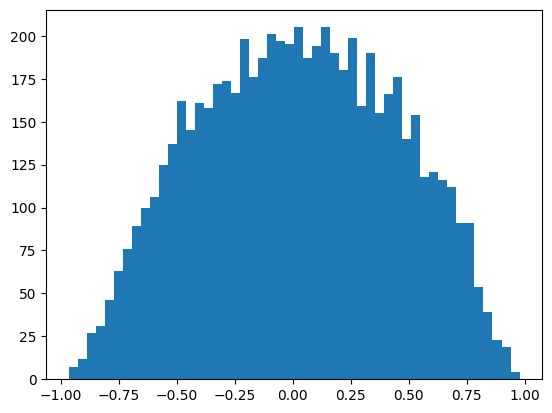

In [46]:
plt.hist(h.view(-1).tolist(), 50)

(array([  3.,   0.,   3.,   0.,   1.,   3.,   6.,  17.,  13.,  18.,  34.,
         40.,  68.,  94., 114., 150., 190., 275., 277., 315., 349., 395.,
        419., 456., 395., 445., 384., 344., 304., 277., 234., 167., 166.,
        125.,  94.,  84.,  47.,  21.,  28.,  17.,   5.,   7.,   5.,   7.,
          3.,   0.,   0.,   0.,   0.,   1.]),
 array([-2.02036476, -1.9350165 , -1.84966825, -1.76431999, -1.67897173,
        -1.59362347, -1.50827521, -1.42292696, -1.3375787 , -1.25223044,
        -1.16688218, -1.08153392, -0.99618567, -0.91083741, -0.82548915,
        -0.74014089, -0.65479263, -0.56944438, -0.48409612, -0.39874786,
        -0.3133996 , -0.22805134, -0.14270308, -0.05735483,  0.02799343,
         0.11334169,  0.19868995,  0.28403821,  0.36938646,  0.45473472,
         0.54008298,  0.62543124,  0.7107795 ,  0.79612775,  0.88147601,
         0.96682427,  1.05217253,  1.13752079,  1.22286904,  1.3082173 ,
         1.39356556,  1.47891382,  1.56426208,  1.64961033,  1.73495859,
 

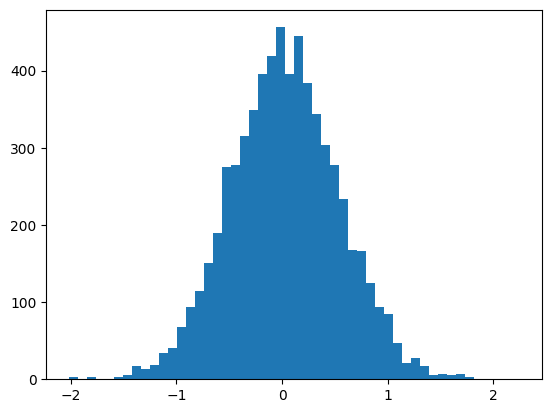

In [47]:
plt.hist(hpreact.view(-1).tolist(), 50)

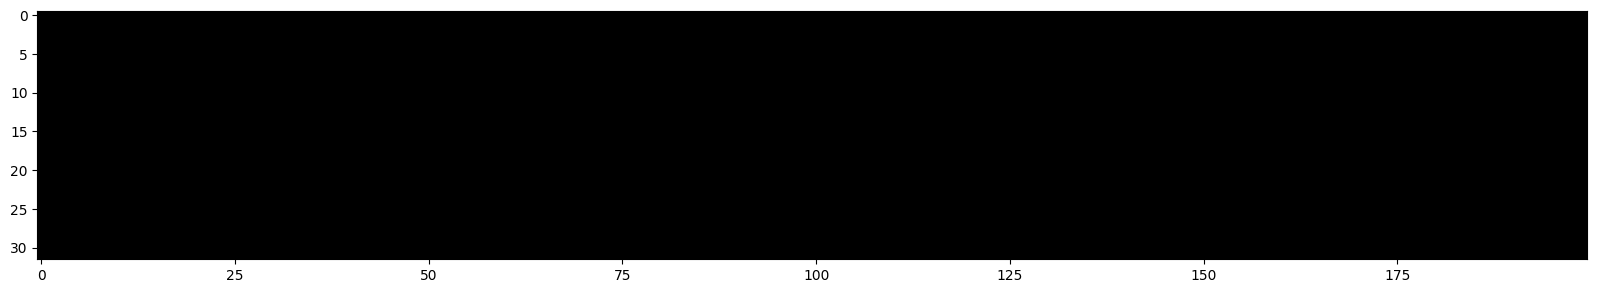

In [48]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# True 显示为 白色
# False 显示为 黑色

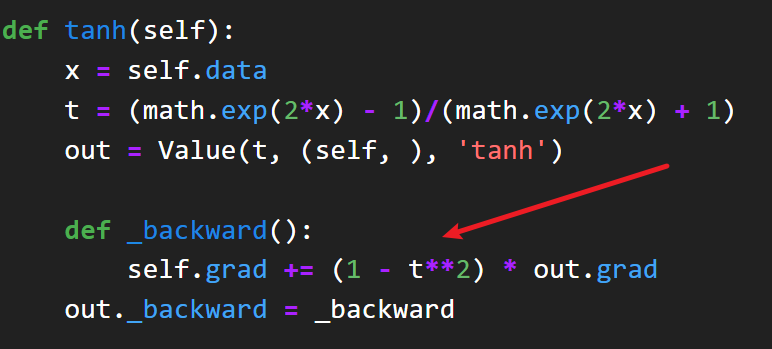

In [ ]:
# 如果这里 hidden layer 200 个 neuron，如果某一列都为白色，表示所有的 X 在 hpreact 都落在了 tanh 的 flat region
# 在这种情况下，这个 init weights/bias 的 neuron 永远无法学习，因为 grad = 0，会 vanish

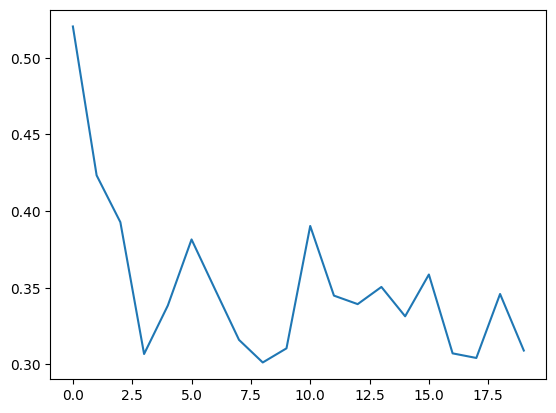

In [19]:
plt.plot(lossi)

In [43]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # 通过训练集传递
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # 测量整个训练集的均值/标准差
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [46]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    # 每一个 neuron 的 firing rate 会 exactly 变成 unit gaussian on this mini-batch(这个例子中是 32 examples)
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0664281845092773
val 2.1050145626068115


在计算交叉熵损失时，通常我们只关注真实标签对应的概率，而不是将所有的概率都加起来。这是因为交叉熵损失的目标是衡量模型在真实标签上的预测概率。

具体来说，交叉熵损失的公式是：
\[ \text{CrossEntropyLoss} = -\sum_{i} y_i \log(\hat{y}_i) \]

其中：
- \( y_i \) 是真实标签的分布（通常是one-hot编码）。
- \( \hat{y}_i \) 是预测的概率分布。

对于单个样本，假设真实标签是第 \( j \) 类（即 \( y_j = 1 \)），那么交叉熵损失可以简化为：
\[ \text{CrossEntropyLoss} = -\log(\hat{y}_j) \]

这是因为one-hot编码的真实标签向量中，只有一个元素为1，其余元素为0。因此，只有真实标签对应的概率会对损失值产生贡献，其余概率的对数来说，交叉熵损失只关注真实标签对应的概率的对数值，因为这反映了模型在真实标签上的预测准确性。其他类别的概率对当前样本的损失没有直接影响。来说，交叉熵损失只关注真实标签对应的概率的对数值，因为这反映了模型在真实标签上的预测准确性。其他类别的概率对当前样本的损失没有直接影响。

In [10]:
# 4-dimensional example of the issue
# 这里假设 character 的数量为 4，最终输出的 logits 数量为 4
logits = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]), tensor(1.6094))

tensor(0.0165) tensor(1.0013)
tensor(0.0152) tensor(3.3073)


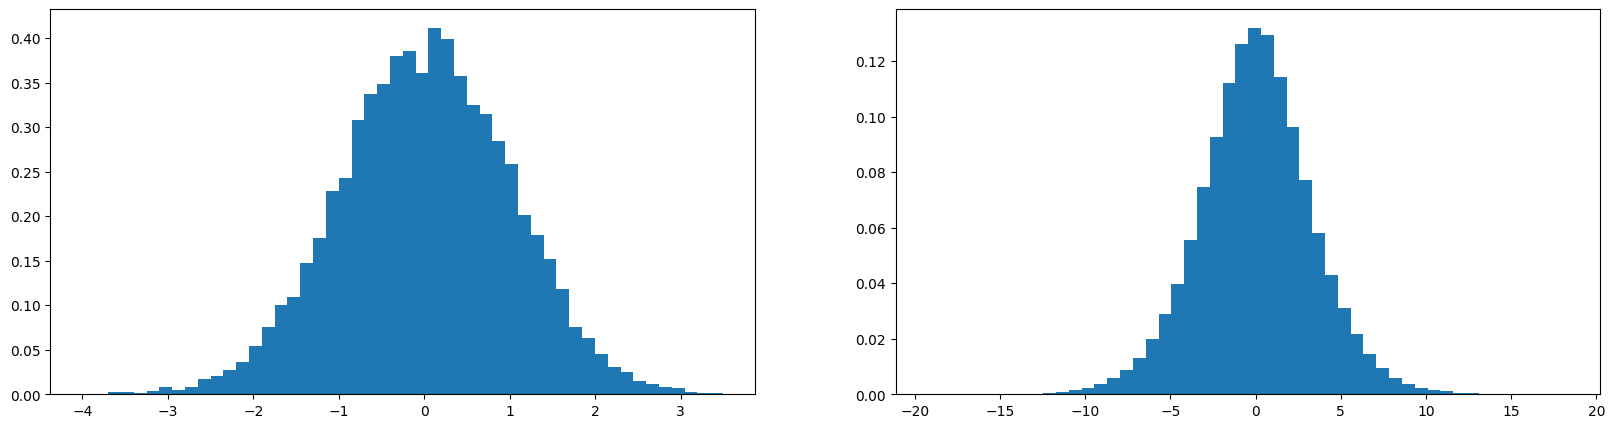

In [10]:
# 我们希望 most of the Neural Nets to have relativey similar activations， aka unit gaussian roughly throughout the neural net
x = torch.randn(1000, 10) # 1000 examples & 10 dimension
w = torch.randn(10, 200) # 输入为 10 dim，有 200 neurons
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()

In [48]:
# summary

In [76]:
# Let's train a deeper network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g) # vocab_size = 27 in this example
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(), # block_size = 3 在这个例子中
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True


47024


In [77]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.2863


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.41%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.66%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.28%


Text(0.5, 1.0, 'activation distribution')

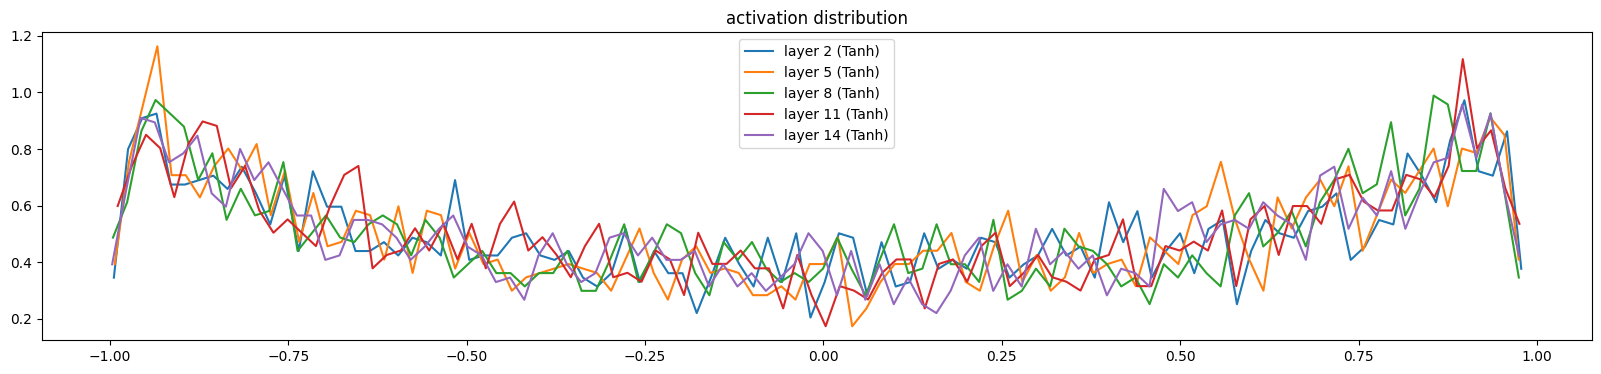

In [78]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')


layer 2 (      Tanh): mean -0.000000, std 3.782019e-03
layer 5 (      Tanh): mean +0.000000, std 3.379367e-03
layer 8 (      Tanh): mean +0.000000, std 3.280967e-03
layer 11 (      Tanh): mean +0.000000, std 2.871718e-03
layer 14 (      Tanh): mean +0.000000, std 2.737710e-03


Text(0.5, 1.0, 'gradient distribution')

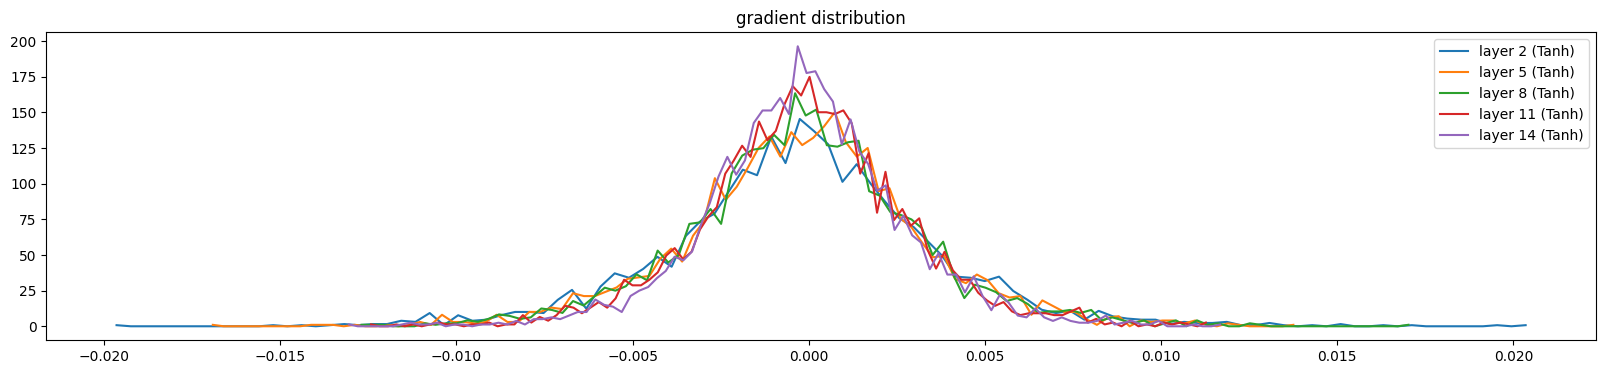

In [79]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')


weight   (27, 10) | mean -0.000000 | std 1.203337e-02 | grad:data ratio 1.202112e-02
weight  (30, 100) | mean +0.000153 | std 9.455311e-03 | grad:data ratio 3.025147e-02
weight (100, 100) | mean +0.000064 | std 8.374568e-03 | grad:data ratio 5.009791e-02
weight (100, 100) | mean -0.000048 | std 7.970662e-03 | grad:data ratio 4.726017e-02
weight (100, 100) | mean -0.000006 | std 6.793362e-03 | grad:data ratio 4.047512e-02
weight (100, 100) | mean -0.000049 | std 6.278434e-03 | grad:data ratio 3.739589e-02
weight  (100, 27) | mean +0.000076 | std 1.068255e-02 | grad:data ratio 6.409587e-02


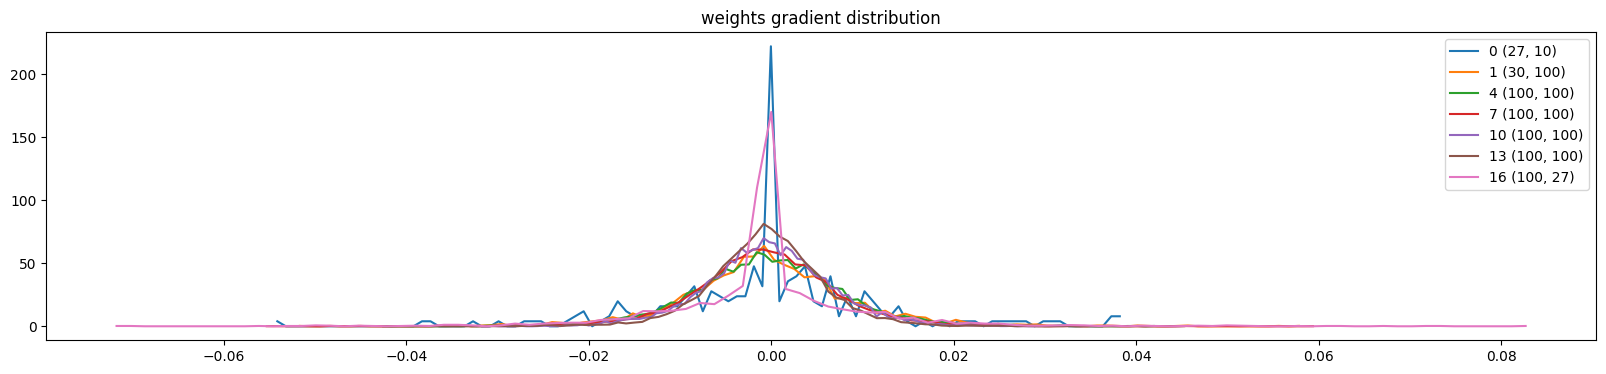

In [80]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

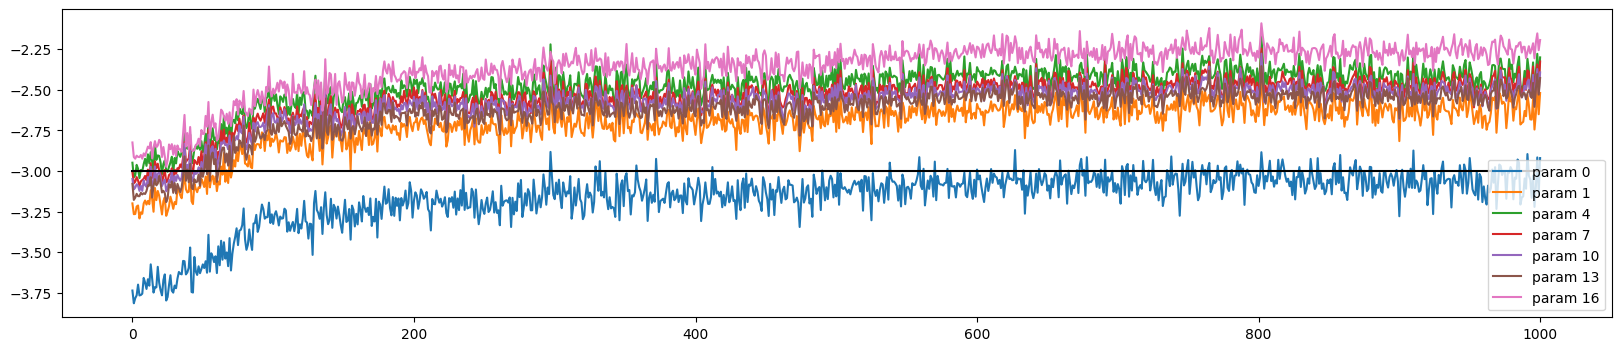

In [81]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);